In [1]:
# from molmap import loadmap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
#IPythonConsole.ipython_useSVG = True
import numpy as np
import pandas as pd
from tqdm import tqdm
from openbabel import pybel
RDLogger.DisableLog('rdApp.*')

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=False,
                          xyplotlabels=False,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    blanks = ['' for i in range(cf.size)]
    font_path = '/usr/share/fonts/truetype/static/Roboto-Regular.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)

    try:
        font_manager.fontManager.addfont('/usr/share/fonts/truetype/static/Roboto-Bold.ttf')  
        plt.rcParams['mathtext.fontset']='cm'
        sns.set_theme(font_scale=1.20,rc={'font.family':font_manager.FontProperties(fname='/usr/share/fonts/truetype/static/Roboto-Bold.ttf').get_name()})
    except:
        pass

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            # stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
            #     accuracy,precision,recall,f1_score)
            stats_text = "Accuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}".format(
                accuracy,precision,recall)
        else:
            stats_text = "Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,
                square=True,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories,
    )

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        # sns.set(font_scale=1.10)
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
def sort_dict(x):
    return {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

def count_place(inh, parameter):
    count = {}
    for s in inh[parameter].unique():
        count[s] = sum(inh[parameter]==s)
    count = sort_dict(count)
    return count

def clean_and_standardize(smiles,ph=7.4,iso=False):
    try:
        # Convert SMILES to RDKit molecule
        mol = Chem.MolFromSmiles(smiles)
        
        # Skip invalid molecules
        if mol is None:
            return None,None

        # Canonicalize the SMILES
        # canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

        # Remove salts and other fragments / Keep only the largest fragment
        fragments = Chem.GetMolFrags(mol, asMols=True)
        largest_fragment = max(fragments, default=None, key=lambda m: m.GetNumAtoms())
        if largest_fragment is None:
            return None,None
        
        u = rdMolStandardize.Uncharger()
        uncharge_mol = u.uncharge(largest_fragment)
        uncharge_smiles = Chem.MolToSmiles(uncharge_mol, isomericSmiles=iso, canonical=True)
        
        ob_mol = pybel.readstring("smi", Chem.MolToSmiles(largest_fragment, isomericSmiles=iso, canonical=True))
        
        ob_mol.OBMol.AddHydrogens(False, True, ph)

        # Convert back to SMILES
        adjusted_smiles = ob_mol.write("smi").strip()

        return adjusted_smiles, uncharge_smiles
    
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None,None

In [4]:
df = pd.read_csv('./source/invitro.csv',encoding='utf-8')
df = df.dropna(subset=['method','place','geneName','type','structure','value','parameter','substanceMeasured','experimentalSystem'])
refine = ['drug','place','experimentalSystem','substanceMeasured','concomitant','value','reference','sourceLink']

In [5]:
inh = df[df['type'] == 'Inhibitor']
sub = df[df['type'] == 'Substrate']

In [6]:
inh['clean_smiles_pH'] = [ clean_and_standardize(s)[1] for s in inh['structure'] ]
len(inh),len(inh.drop_duplicates(subset=['clean_smiles_pH']))

(1181, 283)

In [7]:
sub_list=['CaAM','Digoxin','SiH','SiD','SiR','SiP','SiV']
exp_list=['Caco2','MDR1','rCell']

In [8]:
count_place(inh,'substanceMeasured')

{'Calcein AM': 356,
 'Digoxin': 109,
 'Digoxin1,3': 86,
 'Rhodamine 123': 69,
 'Daunorubicin': 67,
 '[3H]-Digoxin': 64,
 '[Lucifer yellow]': 44,
 'Vinblastine1': 33,
 '[3H]-digoxin': 28,
 '[3H]-vinblastine': 24,
 'LDS-751': 21,
 'Rivaroxaban': 19,
 '[3H]-Daunorubicin': 17,
 'Verapamil2,4': 17,
 'JC1': 15,
 'Doxorubicin': 14,
 '[Bodipy]-Verapamil': 12,
 'Hoechst 33342': 12,
 '[Bodipyl-FL]-Prazosin': 12,
 '[3H]-Talinolol': 12,
 'Paclitaxel': 12,
 'Vinblastine': 11,
 '3H-labeled digoxin': 10,
 'Verapamil': 9,
 'Vanadate': 8,
 'Tetramethylrosamine': 7,
 '[3H]-Vincristine': 6,
 '[14C]-Erythromycin': 6,
 'Colchicine': 5,
 '[14C]-Ximelagatran': 5,
 'Fluo-3': 5,
 'JC-1': 5,
 'Quinidine': 4,
 '[14C]-Inulin': 4,
 '5-Thio-tetramethylrosamine': 3,
 'Loperamide Hydrochloride': 3,
 'Loperamide': 3,
 'Pirarubicin': 3,
 '3H-labeled quinidine': 3,
 'Bisbenzimide H33342': 3,
 'Seletalisib': 2,
 '[3H]-Pitavastatin': 2,
 'Verapamil Hydrochloride': 2,
 '[3H]-Mitoxantrone': 2,
 'Dipyridamole': 2,
 'Ximelaga

In [9]:
count_place(inh,'experimentalSystem')

{'Caco2 cells': 214,
 'LLC-PK1 cells, recombinant': 191,
 'NIH-3T3-G185 cells': 81,
 'MDCKII-MDR1 cells, recombinant': 69,
 'L-MDR1 cells, recombinant': 64,
 'MDR1 expressing LLC-PK1 cells': 45,
 'K562 cells': 37,
 'MDR1-expressing LLC-PK1 cells': 35,
 'Mouse mdr1a expressing LLC-PK1 cells': 26,
 'Mouse mdr1b expressing LLC-PK1 cells': 26,
 'MDCKII cells, recombinant': 22,
 'MDR1 expressing A2780/ADR cells': 21,
 'NIH-3T3 cells, recombinant': 21,
 'MDCK II-MDR1 cells': 17,
 'LLC-GA5-COL150 cells, recombinant': 16,
 'LLC-PK1 cells': 15,
 'Jurkat cells': 15,
 'CCRF-CEM/ ADR5000 cells': 15,
 'MDR1-expressing Caco2 cells': 13,
 'MDR1 transfected LLC-PK1 cells': 12,
 'MDCK-MDR1 cells': 11,
 'HCMEC/ D3 cells': 10,
 'F4-6P cells': 10,
 'MES-SA/ Dx5 cells': 10,
 'B16/F10 cells': 10,
 'P388 VMDR C0.4 cells, recombinant': 9,
 'MDCKII-MDR1 cells': 8,
 'CEM cells': 8,
 'MDR1 exressing CCRF-cEM/VCR 1000 cells': 7,
 'Lymphocyte cells': 7,
 'Caco2 cells, recombinant': 7,
 'MDCKII cells': 7,
 'MDR1 ex

In [10]:
def reset_df(inh,sub_list=['CaAM'],exp_list=['MDR1']):
    print({'sub':sub_list,'exp':exp_list})
    inh_cell = inh[(inh['method']=='Cell line')]
    inh_cell_fda = inh_cell
    inh_cell_fda = inh_cell_fda[inh_cell_fda['geneName']!='abcb4']
    len(inh_cell_fda),len(inh_cell_fda.drop_duplicates(subset=['clean_smiles_pH']))

    data = []
    unit = []
    value = []
    for (s,v) in zip(inh_cell_fda['parameter'],inh_cell_fda['value']):
        if ('IC50' in s):
            data.append('IC50')
            unit.append('uM')
            value.append(v)
        elif 'Ki' in s:
            data.append('Ki')
            unit.append('uM')
            try:
                float(v)
                value.append(str(float(v)/2))
            except:
                # print('Fail to reduce, Ki',v)
                value.append(v)
        else:
            data.append('ratio')
            unit.append('%')
            value.append(v)
    inh_cell_fda['parameter'] = data
    inh_cell_fda['units'] = unit
    inh_cell_fda['value'] = value
    inh_cell_fda=inh_cell_fda.dropna(subset=['value'])

    inh_cell_fda=inh_cell_fda[(inh_cell_fda['parameter']=='IC50')|(inh_cell_fda['parameter']=='Ki')]

    print(len(inh_cell_fda),count_place(inh_cell_fda,'parameter'))
    
    data = []
    for exp in inh_cell_fda['substanceMeasured']:
        if ('Calcein' in exp):
            data.append('CaAM')
        elif ('goxin' in exp):
            data.append('Digoxin')
        elif ('blastine' in exp):
            data.append('SiV')
        elif ('chst' in exp or 'icine' in exp):
            data.append('SiH')
        elif ('damine' in exp):
            data.append('SiR')
        elif ('Daunorubicin' in exp or 'Doxorubicin' in exp):
            data.append('SiD')
        elif ('xel' in exp or 'xol' in exp):
            data.append('SiP')
        else:
            data.append('Others')
    inh_cell_fda['substanceMeasured'] = data
    
    mask = np.zeros(len(inh_cell_fda),np.bool_)
    for s in sub_list:
        mask |= np.array([s in exp for exp in inh_cell_fda['substanceMeasured']])
        
    inh_cell_fda=inh_cell_fda[mask]
    print(len(inh_cell_fda),count_place(inh_cell_fda,'substanceMeasured'))

    data = []
    for exp in inh_cell_fda['experimentalSystem']:
        if 'Caco2' in exp:
            data.append('Caco2')
        elif 'MDR1' in exp:
            data.append('MDR1')
        elif 'recombinant' in exp:
            data.append('rCell')
        else:
            data.append(exp)
    inh_cell_fda['experimentalSystem'] = data
    
    mask = np.zeros(len(inh_cell_fda),np.bool_)
    for s in exp_list:
        mask |= np.array([s in exp for exp in inh_cell_fda['experimentalSystem']])

    # data = []
    # for exp1,exp2 in zip(inh_cell_fda['reference'],inh_cell_fda['experimentalSystem']):
    #     # data.append(exp2+':'+exp1)
    #     data.append(exp1)
    #     # if 'FDA' in exp1 or 'EMA' in exp1:
    #     #     data.append('FDA/EMA')
    #     # else:
    #     #     data.append(exp1)
    # inh_cell_fda['reference'] = data
    
    # print(len(inh_cell_fda),count_place(inh_cell_fda,'experimentalSystem'))
    inh_cell_fda=inh_cell_fda[mask]
    print(len(inh_cell_fda),count_place(inh_cell_fda,'experimentalSystem'))

    no_pure=[]
    for s in inh_cell_fda['value']:
        try:
            float(s)
            no_pure.append(False)
        except:
            no_pure.append(True)
        
    return inh_cell_fda,no_pure

import re
def string2value(inh_cell_fda):
    l=[]
    # print('origin:',len(set(inh_cell_fda['clean_smiles_pH'])),len(inh_cell_fda))

    for s in inh_cell_fda['value']:
        l.append(re.findall(r"(?:\d*\.*\d+)", s))

    for i in range(len(l)):
        t = l[i]
        for j in range(len(t)):
            t[j] = float(t[j])

        if (len(t)==0):
            l[i]=None
            continue
            
        if (len(t)==1):
            total = float(t[0])
        elif (len(t)==2):
            total = sum([float(s) for s in t])/2
            
        if total < 1e-4 or total > 10000:
            total=None

        l[i]=total
    
    l = np.array(l)
    inh_cell_fda['value_num']=l
    inh_cell_fda=inh_cell_fda.dropna(subset=['value_num'])
    
    # print('process:',len(set(inh_cell_fda['clean_smiles_pH'])),len(inh_cell_fda))
    # print()
    return inh_cell_fda

def process_df(inh,sub_list,exp_list,cutoff1=15.0,cutoff2=50.0):
    inh_cell_fda,_=reset_df(inh,sub_list,exp_list)
    inh_cell_fda=string2value(inh_cell_fda)
    flag_list = []
    data_list = []
    tho2 = cutoff1
    tho3 = cutoff2
    l=np.array(inh_cell_fda['value_num'].tolist())
    for i in range(len(inh_cell_fda)):
        data = inh_cell_fda.iloc[i]
        param,val,unit = data['parameter'],data['value'],data['units']

        eps = 1e-6

        if ('<' in val and l[i] <= tho2):
            data_list.append(0)
        elif ('>' in val and l[i] >= tho3):
            data_list.append(2)
        elif ('>' in val or '<' in val):
            data_list.append(None)
        elif l[i] <= tho2:
            data_list.append(0)
        elif l[i]>tho2 and l[i]<tho3:
            data_list.append(1)
        else:
            data_list.append(2)

    inh_cell_fda['origin'] = inh_cell_fda['value']
    inh_cell_fda['value'] = data_list
    inh_cell_fda=inh_cell_fda.dropna(subset=['value'])
    print('process:',len(set(inh_cell_fda['clean_smiles_pH'])),'(',tho2,tho3,')',count_place(inh_cell_fda,'value'))
    print()
    
    return inh_cell_fda

In [11]:
inh_cell_fda,_=reset_df(inh,sub_list,exp_list)
inh_cell_fda=string2value(inh_cell_fda)

{'sub': ['CaAM', 'Digoxin', 'SiH', 'SiD', 'SiR', 'SiP', 'SiV'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
928 {'CaAM': 358, 'Digoxin': 300, 'SiD': 98, 'SiV': 71, 'SiR': 70, 'SiH': 17, 'SiP': 14}
679 {'MDR1': 303, 'Caco2': 191, 'rCell': 185}


In [12]:
count_place(inh_cell_fda,'concomitant')

{'[Digoxin]': 204,
 '[Calcein acetomethoxy ester]': 143,
 '[Vinblastine Sulfate]': 38,
 '[Daunorubicin Hydrochloride]': 29,
 '[Rhodamine 123]': 12,
 '[Rhodamine]': 8,
 '[Doxorubicin, Liposomal]': 3,
 '[Paclitaxel]': 2,
 nan: 0}

In [13]:
from scipy import stats

In [14]:
inh_cell_fda,no_pure=reset_df(inh,sub_list,exp_list)
inh_cell_fda=string2value(inh_cell_fda)
print()
for keys in inh_cell_fda['substanceMeasured'].unique():
    data=defaultdict(list)
    flag=[]
    smi_dict=defaultdict(str)
    print(keys)
    for i in range(len(inh_cell_fda)):
        exp = inh_cell_fda.iloc[i]['drug']
        smi = inh_cell_fda.iloc[i]['clean_smiles_pH']
        sub = inh_cell_fda.iloc[i]['substanceMeasured']
        val_o = inh_cell_fda.iloc[i]['value']
        val = inh_cell_fda.iloc[i]['value_num']

        if ((keys == sub) and (
            'cein' in exp or
            'goxin' in exp or
            'damine' in exp or
            'blastine' in exp or
            'chst' in exp or
            'phine' in exp or
            'icine' in exp or
            'chst' in exp or
            'taxel' in exp or
            'bicin' in exp ) 
        ):
            flag.append(True)
            data[smi+'_'+sub].append(val)
            smi_dict[smi+'_'+sub]=exp
        else:
            flag.append(False)
    
    test_list=[]
    for k,v in data.items():
        # p_value_max=round(stats.ttest_1samp(v, np.array(v).max())[1],3)
        # p_value_min=round(stats.ttest_1samp(v, np.array(v).min())[1],3)
        print(smi_dict[k],k.split('_')[1],len(v),v)
    print()

{'sub': ['CaAM', 'Digoxin', 'SiH', 'SiD', 'SiR', 'SiP', 'SiV'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
928 {'CaAM': 358, 'Digoxin': 300, 'SiD': 98, 'SiV': 71, 'SiR': 70, 'SiH': 17, 'SiP': 14}
679 {'MDR1': 303, 'Caco2': 191, 'rCell': 185}

Digoxin
Vinblastine Sulfate Digoxin 5 [7.5, 17.8, 34.0, 70.0, 10.0]
Morphine Sulfate Digoxin 2 [100.0, 100.0]
Daunorubicin Digoxin 1 [55.5]
Colchicine Digoxin 1 [100.0]
Paclitaxel Digoxin 1 [100.0]

SiH
Vinblastine1 SiH 1 [15.05]

SiD
Vinblastine Sulfate SiD 1 [18.0]
Paclitaxel SiD 1 [27.8]

SiV

CaAM
Vinblastine1 CaAM 4 [10.5, 14.5, 50.0, 50.0]
Colchicine CaAM 2 [50.0, 50.0]
Digoxin1,3 CaAM 2 [50.0, 50.0]
Morphine CaAM 2 [50.0, 50.0]

SiR
Vinblastine1 SiR 1 [18.0]

SiP
Daunorubicin SiP 1 [1.25]
Doxorubicin SiP 1 [4.25]
Vinblastine1 SiP 1 [18.25]



In [15]:
inh_cell_fda,no_pure=reset_df(inh,sub_list,exp_list)
inh_cell_fda=string2value(inh_cell_fda)
data=defaultdict(list)
flag=[]
smi_dict=defaultdict(str)
for i in range(len(inh_cell_fda)):
    exp = inh_cell_fda.iloc[i]['drug']
    smi = inh_cell_fda.iloc[i]['clean_smiles_pH']
    sub = inh_cell_fda.iloc[i]['substanceMeasured']
    val_o = inh_cell_fda.iloc[i]['value']
    
    val = inh_cell_fda.iloc[i]['value_num']
    if (
        (
        ('Vinblast' in exp and
        'No' not in exp))
    ):
        flag.append(True)
        if val>2:
            data[smi+'_'+sub].append(val)
        smi_dict[smi+'_'+sub]=exp
    else:
        flag.append(False)
for k,v in data.items():
    print(smi_dict[k],k.split('_')[1],v,(round(np.array(v).mean(),3),round(np.array(v).std(),3)))

{'sub': ['CaAM', 'Digoxin', 'SiH', 'SiD', 'SiR', 'SiP', 'SiV'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
928 {'CaAM': 358, 'Digoxin': 300, 'SiD': 98, 'SiV': 71, 'SiR': 70, 'SiH': 17, 'SiP': 14}
679 {'MDR1': 303, 'Caco2': 191, 'rCell': 185}
Vinblastine1 CaAM [10.5, 14.5, 50.0, 50.0] (31.25, 18.803)
Vinblastine Sulfate Digoxin [7.5, 17.8, 34.0, 70.0, 10.0] (27.86, 23.014)
Vinblastine Sulfate SiD [18.0] (18.0, 0.0)
Vinblastine1 SiR [18.0] (18.0, 0.0)
Vinblastine1 SiH [15.05] (15.05, 0.0)
Vinblastine1 SiP [18.25] (18.25, 0.0)


In [16]:
inh_cell_fda,no_pure=reset_df(inh,sub_list,exp_list)
inh_cell_fda=string2value(inh_cell_fda)
data=defaultdict(list)
flag=[]
smi_dict=defaultdict(str)
for i in range(len(inh_cell_fda)):
    exp = inh_cell_fda.iloc[i]['drug']
    smi = inh_cell_fda.iloc[i]['clean_smiles_pH']
    sub = inh_cell_fda.iloc[i]['substanceMeasured']
    val = inh_cell_fda.iloc[i]['value_num']
    
    if (
        'qudar' in exp or
        'idar' in exp
    ):
        # print(exp,val)
        flag.append(True)
        data[smi+'_'+sub].append(val)
        smi_dict[smi+'_'+sub]=exp
        # data.append(val)
    else:
        flag.append(False)
for k,v in data.items():
    print(smi_dict[k],k.split('_')[1],v,min(v),max(v))

{'sub': ['CaAM', 'Digoxin', 'SiH', 'SiD', 'SiR', 'SiP', 'SiV'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
928 {'CaAM': 358, 'Digoxin': 300, 'SiD': 98, 'SiV': 71, 'SiR': 70, 'SiH': 17, 'SiP': 14}
679 {'MDR1': 303, 'Caco2': 191, 'rCell': 185}
Zosuquidar2 Digoxin [0.024] 0.024 0.024
Elacridar (GF120918)2 SiH [0.027] 0.027 0.027
Elacridar (GF120918)2 Digoxin [0.02, 0.055, 0.09, 0.195, 0.22] 0.02 0.22
Elacridar (GF120918)2 SiV [0.043] 0.043 0.043
Elacridar SiD [0.1] 0.1 0.1
Zosuquidar2 SiD [0.1] 0.1 0.1
Elacridar CaAM [0.1] 0.1 0.1
Tariquidar CaAM [0.1] 0.1 0.1


In [17]:
def test_v1(data_dict,dropna=True,strict=True):
    from scipy.stats import chisquare,multinomial
    val_list = []
    for smi in data_dict.keys():
        
        temp = np.array(data_dict[smi])
        total=len(temp)
        
        results=np.zeros(3)
        for l in range(3):
            results[l]=sum(temp==l)
        
        observed=np.zeros(2)
        observed[0]=sum(temp<=1)
        observed[1]=sum(temp==2)

        # if strict = Ture, retain the consistent results without the ambigious regions, i.e., labels = 1
        # if strict = False, retain the consistent results with the ambigious regions, i.e., labels = 1 is would be considered as the inhibitors
        if strict:
            if results[results.argmax()]==total:
                val_list.append(results.argmax())
            else:
                val_list.append(None)
        else:
            # val_list.append(0 if observed[0]>observed[1] else 2)
            if observed[observed.argmax()]==total:
                if results.argmax()==0 and results[0]==results[1]:
                        val_list.append(1)
                else:
                    val_list.append(results.argmax())
            else:
                val_list.append(None)
    if dropna:
        return [(k,v) for k,v in zip(data_dict.keys(),val_list) if v is not None]
    else:
        return [(k,v) for k,v in zip(data_dict.keys(),val_list) ]

In [18]:
def pre_merge_df(inh_cell_fda,inh_cell_fda1=None):
    if inh_cell_fda1 is None:
        inh_cell_fda1=inh_cell_fda
    print('origin:',len(set(inh_cell_fda['clean_smiles_pH'])),len(inh_cell_fda))
    inh_cell_fda['clean_smiles_pH'] = [ clean_and_standardize(s)[1] for s in inh_cell_fda['structure'] ]
    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    
    data_dict0 = defaultdict(list)
    for i in range(len(inh_cell_fda)):
        data = inh_cell_fda.iloc[i]
        smiles = data['clean_smiles_pH']
        smiles_dict[smiles].append(data['drug'])
        sub = data['substanceMeasured']
        exp = data['experimentalSystem']
        param,val,unit = data['parameter'],data['value'],data['units']
        data_dict0['_'.join([smiles,sub,exp])].append(val)
    
    for k,v in test_v1(data_dict0,strict=False):
        data_dict[k].append(v)
    
    data_dict1 = defaultdict(list)
    for i in range(len(inh_cell_fda1)):
        data = inh_cell_fda1.iloc[i]
        smiles = data['clean_smiles_pH']
        smiles_dict[smiles].append(data['drug'])
        sub = data['substanceMeasured']
        exp = data['experimentalSystem']
        param,val,unit = data['parameter'],data['value'],data['units']
        data_dict1['_'.join([smiles,sub,exp])].append(val)
        
    for k,v in test_v1(data_dict1,strict=True):
        data_dict[k].append(v)
        
    val_list = []
    for smi in data_dict.keys():
        temp = np.array(data_dict[smi])
        val_list.append(temp[-1])

    keys = list(data_dict.keys())
    drug = []
    subs = []
    exps = []
    smiles = []
    for key in keys:
        smi,sub,exp = key.split('_')
        subs.append(sub)
        exps.append(exp)
        drug.append(smiles_dict[smi][0])
        smiles.append(smi)
    df_process = pd.DataFrame({'drug':drug,'smiles':smiles,'sub':subs,'exp':exps,'label':val_list})
    print('process:',len(set(df_process['smiles'])),len(df_process))
    print()
    return df_process

def merge_df(inh_cell_fda,strict=True):
    print('origin:',len(set(inh_cell_fda['smiles'])),len(inh_cell_fda))
    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(inh_cell_fda)):
        data = inh_cell_fda.iloc[i]
        smiles,sub,exp,val = data['smiles'],data['sub'],data['exp'],data['label']
        smiles_dict[smiles].append(data['drug'])
        data_dict['_'.join([smiles,sub])].append(val)

    # merge different cell's data
    val_list = []
    for k,v in test_v1(data_dict,dropna=False,strict=False):
        val_list.append(v)

    keys = list(data_dict.keys())
    drug = []
    subs = []
    smiles = []
    for key in keys:
        smi,sub = key.split('_')
        subs.append(sub)
        drug.append(smiles_dict[smi][0])
        smiles.append(smi)
    df_process = pd.DataFrame({'drug':drug,'smiles':smiles,'sub':subs,'label':val_list}).dropna()

    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(inh_cell_fda)):
        data = inh_cell_fda.iloc[i]
        smiles,sub,val = data['smiles'],data['sub'],data['label']
        smiles_dict[smiles].append(data['drug'])
        data_dict[smiles].append(val)
    
    # merge different sub's data
    val_list = []
    for k,v in test_v1(data_dict,dropna=False,strict=False):
        val_list.append(v)

    smiles = list(data_dict.keys())
    drug = [ smiles_dict[smi][0] for smi in smiles ]
    df_process = pd.DataFrame({'drug':drug,'smiles':smiles,'label':val_list}).dropna()
    print('process:',len(set(df_process['smiles'])),len(df_process))
    print()
    return df_process

def merge_df_inv(inh_cell_fda,strict=True):
    print('origin:',len(set(inh_cell_fda['smiles'])),len(inh_cell_fda))
    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(inh_cell_fda)):
        data = inh_cell_fda.iloc[i]
        smiles,sub,exp,val = data['smiles'],data['sub'],data['exp'],data['label']
        smiles_dict[smiles].append(data['drug'])
        data_dict['_'.join([smiles,exp])].append(val)

    # merge different cell's data
    val_list = []
    for k,v in test_v1(data_dict,dropna=False,strict=False):
        val_list.append(v)

    keys = list(data_dict.keys())
    drug = []
    subs = []
    smiles = []
    for key in keys:
        smi,sub = key.split('_')
        subs.append(sub)
        drug.append(smiles_dict[smi][0])
        smiles.append(smi)
    df_process = pd.DataFrame({'drug':drug,'smiles':smiles,'sub':subs,'label':val_list}).dropna()

    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(inh_cell_fda)):
        data = inh_cell_fda.iloc[i]
        smiles,sub,val = data['smiles'],data['sub'],data['label']
        smiles_dict[smiles].append(data['drug'])
        data_dict[smiles].append(val)
    
    # merge different sub's data
    val_list = []
    for k,v in test_v1(data_dict,dropna=False,strict=False):
        val_list.append(v)

    smiles = list(data_dict.keys())
    drug = [ smiles_dict[smi][0] for smi in smiles ]
    df_process = pd.DataFrame({'drug':drug,'smiles':smiles,'label':val_list}).dropna()
    print('process:',len(set(df_process['smiles'])),len(df_process))
    print()
    return df_process

def check_df(inh_cell_fda):
    for keys in inh_cell_fda['sub'].unique():
        data=defaultdict(list)
        flag=[]
        smi_dict=defaultdict(str)
        print(keys)
        for i in range(len(inh_cell_fda)):
            exp = inh_cell_fda.iloc[i]['drug']
            smi = inh_cell_fda.iloc[i]['smiles']
            sub = inh_cell_fda.iloc[i]['sub']
            val = inh_cell_fda.iloc[i]['label']

            if ((keys == sub) and (
                'cein' in exp or
                'goxin' in exp or
                'damine' in exp or
                'blastine' in exp or
                'chst' in exp or
                'phine' in exp or
                'icine' in exp or
                'chst' in exp or
                'taxel' in exp or
                'bicin' in exp ) 
            ):
                flag.append(True)
                data[smi+'_'+sub].append(val)
                smi_dict[smi+'_'+sub]=exp
            else:
                flag.append(False)

        test_list=[]
        for k,v in data.items():
            p_value_max=round(stats.ttest_1samp(v, np.array(v).max())[1],3)
            p_value_min=round(stats.ttest_1samp(v, np.array(v).min())[1],3)
            print(smi_dict[k],k.split('_')[1],len(v),v)
        print()
        
def calc_confict(df_process,df_vivo,drop=False):
    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(df_process)):
        data = df_process.iloc[i]
        smiles = data['smiles']
        try:
            smiles_dict[smiles].append(data['drug'])
        except:
            pass
        val = data['label']
        data_dict[smiles].append(val)

    for i in range(len(df_vivo)):
        data = df_vivo.iloc[i]
        smi = data['smiles']
        smiles_dict[smi].append(data['drug'])
        val = data['label']
        if not drop:
            data_dict[smi].append(val)
        elif len(data_dict[smi])>0:
            data_dict[smi].append(val)
        else:
            del data_dict[smi]

    count=defaultdict(list)
    for k,v in data_dict.items():
        if len(v)==2:
            if v[0]!=v[1]:
                print(smiles_dict[k][0],v)
            count[v[1]].append(v[0]!=v[1])
    print()
    
    val_list=[]
    for v in data_dict.values():
        if drop and len(v)==2 and v[0]!=v[1]:
            print(v)
            val_list.append(None)
            continue
        try:
            val_list.append(v[-1])
        except:
            assert False
    
    smiles = list(data_dict.keys())
    drug = [ smiles_dict[smi][0] if len(smiles_dict[smi])>0 else None for smi in smiles ]
    temp = pd.DataFrame({'drug':drug,'smiles':smiles,'label':val_list}).dropna(subset=['label'])

    total=[]
    for k,v in count.items():
        print('label:',k)
        if len(v)>0:
            print(sum(v),len(v),sum(v)/len(v))
        total.append(sum(v)/len(v))
    if len(total)>0:
        print('total')
        print(total,sum(total)/2)
        
    return temp

In [19]:
labels = ['TN','FP','FN','TP']
categories = ['', '']
def show_confict(df_process,df_vivo,drop=False):
    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(df_process)):
        data = df_process.iloc[i]
        smiles = data['smiles']
        try:
            smiles_dict[smiles].append(data['drug'])
        except:
            pass
        val = data['label']
        data_dict[smiles].append(val)

    for i in range(len(df_vivo)):
        data = df_vivo.iloc[i]
        smi = data['smiles']
        smiles_dict[smi].append(data['drug'])
        val = data['label']
        if not drop:
            data_dict[smi].append(val)
        elif len(data_dict[smi])>0:
            data_dict[smi].append(val)
        else:
            del data_dict[smi]

    count=defaultdict(list)
    for k,v in data_dict.items():
        if len(v)==2:
            if v[0]!=v[1]:
                print(smiles_dict[k][0],v)
            count[v[1]].append(v[0]!=v[1])
    print()

    label_list=[]
    truth_list=[]
    for v in data_dict.values():
        if len(v)==2:
            label_list.append(v[0])
            truth_list.append(v[1])
        # else:
        #     label_list.append(None)
        #     truth_list.append(None)

    return confusion_matrix(truth_list,label_list)

In [20]:
print('Proving orderless')
inh_cell_fda0=process_df(inh,sub_list,exp_list)
print('Stage I: Cleaning')
inh_cell_fda0=pre_merge_df(inh_cell_fda0)
print(len(inh_cell_fda0['sub'].unique()),len(inh_cell_fda0['exp'].unique()))
print('Stage II: Merging')

print('cell line * probe substrate')
inh_cell_fda0_inv=merge_df_inv(inh_cell_fda0)

print('probe substrate * cell line')
inh_cell_fda0=merge_df(inh_cell_fda0)

print('For canonical substrates')
inh_cell_fda1=process_df(inh,['CaAM','Digoxin','SiR','SiH'],exp_list)

print('Stage I: Cleaning')
inh_cell_fda1=pre_merge_df(inh_cell_fda1)
print(len(inh_cell_fda1['sub'].unique()),len(inh_cell_fda1['exp'].unique()))
print('Stage II: Merging')
print('cell line * probe substrate')
inh_cell_fda1_inv=merge_df_inv(inh_cell_fda1)
print('probe substrate * cell line')
inh_cell_fda1=merge_df(inh_cell_fda1)

Proving orderless
{'sub': ['CaAM', 'Digoxin', 'SiH', 'SiD', 'SiR', 'SiP', 'SiV'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
928 {'CaAM': 358, 'Digoxin': 300, 'SiD': 98, 'SiV': 71, 'SiR': 70, 'SiH': 17, 'SiP': 14}
679 {'MDR1': 303, 'Caco2': 191, 'rCell': 185}
process: 199 ( 15.0 50.0 ) {0.0: 378, 2.0: 167, 1.0: 117}

Stage I: Cleaning
origin: 199 662
process: 197 391

7 3
Stage II: Merging
cell line * probe substrate
origin: 197 391
process: 177 177

probe substrate * cell line
origin: 197 391
process: 177 177

For canonical substrates
{'sub': ['CaAM', 'Digoxin', 'SiR', 'SiH'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
745 {'CaAM': 358, 'Digoxin': 300, 'SiR': 70, 'SiH': 17}
555 {'MDR1': 258, 'Caco2': 178, 'rCell': 119}
process: 188 ( 15.0 50.0 ) {0.0: 300, 2.0: 149, 1.0: 89}

Stage I: Cleaning
origin: 188 538
process: 185 306

4 3
Stage II: Merging
cell line * probe substrate
origin: 185 306
process: 171 171

probe substrate * cell line
orig

In [21]:
inh_cell_fda1=process_df(inh,['CaAM','Digoxin','SiR','SiH'],exp_list)

{'sub': ['CaAM', 'Digoxin', 'SiR', 'SiH'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
745 {'CaAM': 358, 'Digoxin': 300, 'SiR': 70, 'SiH': 17}
555 {'MDR1': 258, 'Caco2': 178, 'rCell': 119}
process: 188 ( 15.0 50.0 ) {0.0: 300, 2.0: 149, 1.0: 89}



In [22]:
# inh_cell_fda0=process_df(inh,sub_list,exp_list,10,10)
# inh_cell_fda0=pre_merge_df(inh_cell_fda0)
# inh_cell_fda0=merge_df(inh_cell_fda0)

inh_cell_fda1=process_df(inh,['CaAM','Digoxin','SiR','SiH'],exp_list)
inh_cell_fda1=pre_merge_df(inh_cell_fda1)
inh_cell_fda1=merge_df(inh_cell_fda1)

# inh_cell_fda0['label']=[ True if s<=0 else (False if s==2 else None) for s in inh_cell_fda0['label'].tolist()]
inh_cell_fda1['label']=[ True if s<=0 else (False if s==2 else None) for s in inh_cell_fda1['label'].tolist()]
# inh_cell_fda0=inh_cell_fda0.dropna(subset=['label'])
inh_cell_fda1=inh_cell_fda1.dropna(subset=['label'])

# print(len(inh_cell_fda0),count_place(inh_cell_fda0,'label'))
print(len(inh_cell_fda1),count_place(inh_cell_fda1,'label'))

# _=calc_confict(inh_cell_fda0,inh_cell_fda1)
# print()

inh_cell_fda=inh_cell_fda1

# print('Merging these two datasets')
# inh_cell_fda0=inh_cell_fda0[inh_cell_fda0['label']==False]
# inh_cell_fda=calc_confict(inh_cell_fda1,inh_cell_fda0,drop=True)

# cf=show_confict(inh_cell_fda1,inh_cell_fda0)
# make_confusion_matrix(cf, 
#                       group_names=labels,
#                       categories=categories, 
#                       cmap='Blues')
# plt.show()

# for name in ['inhibitors_refine']:
#     data_prepare_stage1(name,'./','./tmp/pH')
#     data_prepare_stage1(name,'./','./tmp/neu')
# for name in ['inhibitors_refine']:
#     data_prepare(name,'./','./tmp/pH')

print('Results',len(inh_cell_fda),count_place(inh_cell_fda,'label'))

{'sub': ['CaAM', 'Digoxin', 'SiR', 'SiH'], 'exp': ['Caco2', 'MDR1', 'rCell']}
1181 {'IC50': 939, 'Ki': 242}
745 {'CaAM': 358, 'Digoxin': 300, 'SiR': 70, 'SiH': 17}
555 {'MDR1': 258, 'Caco2': 178, 'rCell': 119}
process: 188 ( 15.0 50.0 ) {0.0: 300, 2.0: 149, 1.0: 89}

origin: 188 538
process: 185 306

origin: 185 306
process: 171 171

140 {True: 73, False: 67}
Results 140 {True: 73, False: 67}


df_vivo {False: 32, True: 22}
df_vivo_test {False: 41, True: 22}
refine {True: 73, False: 67}
inh_classes {True: 1726, False: 976}

Rifampin [True, False]
Darunavir Ethanolate [True, False]
Dihydroergocristine [True, False]
Atorvastatin Calcium [True, False]
Dihydroergotamine Mesylate [True, False]
Levofloxacin [True, False]
Paroxetine Hydrochloride [True, False]
Fluoxetine Hydrochloride [True, False]
Dihydroergocryptine [True, False]
Sulfentanil [False, True]
Lansoprazole [True, False]
Captopril [True, False]
Paclitaxel [True, False]
Daunorubicin [True, False]



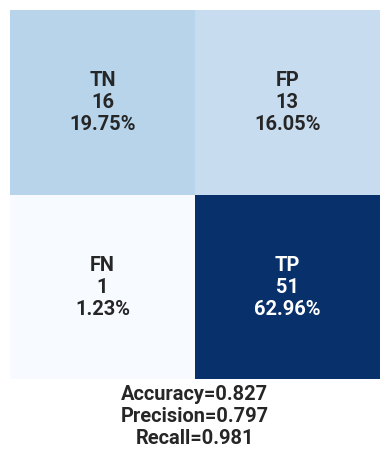


Carvedilol [True, False]
Nefazodone Hydrochloride [True, False]
Atorvastatin Calcium [True, False]
Paroxetine Hydrochloride [True, False]



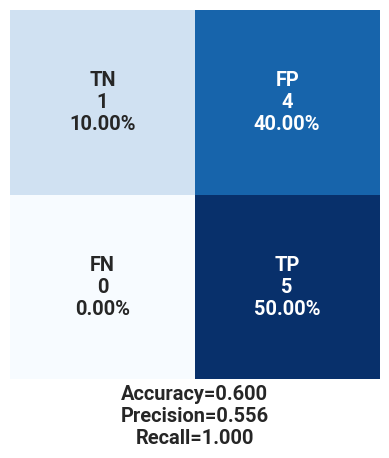


Carvedilol [True, False]
Lurasidone Hydrochloride [True, False]
Vorapaxar Sulfate [True, False]
Istradefylline [True, False]
Darunavir Ethanolate [False, True]



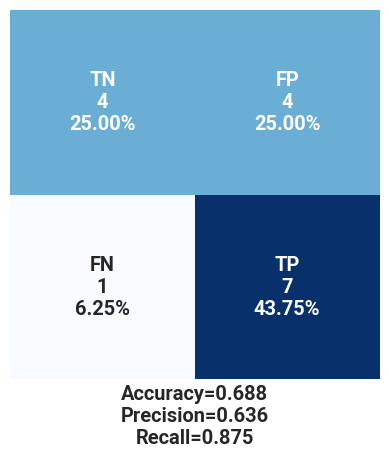

In [23]:
inh_classes= pd.read_csv('../data_classes/inhibitors_classes.csv')
df_vivo = pd.read_csv('inhibitors_vivo.csv')
df_vivo=df_vivo.dropna()
df_vivo_test=pd.read_csv('inhibitors_vivo_test.csv')
df_vivo_test=df_vivo_test.dropna()
print('df_vivo',count_place(df_vivo,'label'))
print('df_vivo_test',count_place(df_vivo_test,'label'))
print('refine',count_place(inh_cell_fda,'label'))
print('inh_classes',count_place(inh_classes,'label'))
print()
cf=show_confict(inh_classes,inh_cell_fda)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig('../../../image/'+'inhLow2High.png',bbox_inches='tight',transparent=True,)
plt.show()
print()
cf=show_confict(inh_classes,df_vivo_test)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig('../../../image/'+'inhLow2Vivo.png',bbox_inches='tight',transparent=True,)
plt.show()
print()
cf=show_confict(inh_cell_fda,df_vivo_test)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig('../../../image/'+'inhHigh2Vivo.png',bbox_inches='tight',transparent=True,)
plt.show()
print()

In [24]:
df_merge=calc_confict(inh_cell_fda,df_vivo)
print(len(df_vivo),count_place(df_vivo,'label'))
len(df_merge),count_place(df_merge,'label')

Vorapaxar Sulfate [True, False]
Darunavir Ethanolate [False, True]

label: True
1 8 0.125
label: False
1 4 0.25
total
[0.125, 0.25] 0.1875
54 {False: 32, True: 22}


(182, {False: 95, True: 87})

In [25]:
inh_com= pd.read_csv('../data_extra/competitive.csv')
inh_com['groundTruth']=[False,False,True,False,False,False,True,True,None,False,True,False,False]

In [26]:
inh_com

,drug,smiles,groundTruth
0,Morphine,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,False
1,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,False
2,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,True
3,Hoechst_33342,CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[n...,False
4,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,False
5,Rhodamine_123,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12,False
6,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,True
7,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,True
8,Valproic_acid,CCCC(CCC)C(=O)O,None
9,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,False


In [27]:
inh_com['label']=inh_com['groundTruth']

In [28]:
from copy import deepcopy
def validation(df_process,inh_com,dropna=True):
    smi_mask=list(inh_com['smiles'])
    drug_dict={}
    turth_dict={}
    for i,smi in enumerate(smi_mask):
        drug_dict[smi]=inh_com.iloc[i]['drug']
        turth_dict[smi]=inh_com.iloc[i]['groundTruth']
    flag=[ exp in smi_mask for exp in df_process['smiles'] ]
    df=deepcopy(df_process[flag])
    df['drug']=list([ drug_dict[smi] for smi in df['smiles'] ])
    df['groundTruth']=list([ turth_dict[smi] for smi in df['smiles'] ])
    df=df[['drug','smiles','label','groundTruth']]
    if dropna:
        df=df.dropna()
    return df

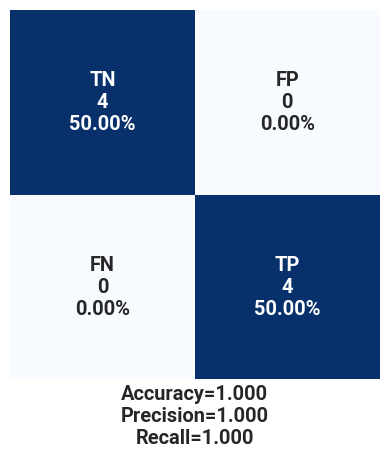

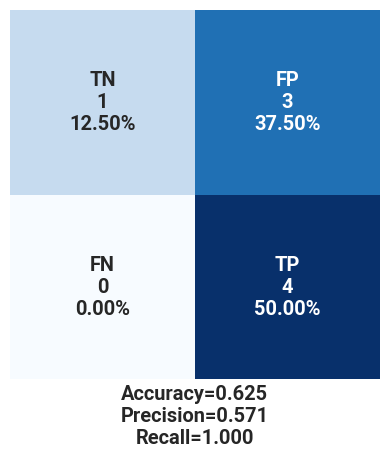

In [29]:
# cf1=validation(inh_cell_fda,inh_com)
# cf_matrix1 = confusion_matrix(cf1['label'], cf1['groundTruth'])
cf_matrix1=show_confict(inh_cell_fda,inh_com)
make_confusion_matrix(cf_matrix1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig('../../../image/'+'inhHigh2Ground.png',bbox_inches='tight',transparent=True,)
plt.show()
cf1=validation(inh_classes,inh_com)
cf_matrix1 = confusion_matrix(cf1['groundTruth'],cf1['label'])
make_confusion_matrix(cf_matrix1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig('../../../image/'+'inhLow2Ground.png',bbox_inches='tight',transparent=True,)
plt.show()

In [30]:
Low=validation(inh_classes,inh_com,dropna=False)

In [31]:
Low

,drug,smiles,label,groundTruth
396,Elacridar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,True,True
663,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,True,False
1258,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,True,True
1939,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,True,True
1941,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,True,True
2376,Hoechst_33342,CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[n...,False,False
2409,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,True,False
2423,Daunorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(C...,True,False


In [32]:
High=validation(df_merge,inh_com,dropna=False)

In [33]:
High

,drug,smiles,label,groundTruth
1,Elacridar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,True,True
7,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,True,True
13,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,True,True
21,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,True,True
80,Morphine,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,False,False
84,Daunorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(C...,False,False
115,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,False,False
116,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,False,False


In [34]:
Gmatrix=pd.merge(Low, High, on=['smiles','drug','groundTruth'],how='outer')[['drug','smiles','groundTruth','label_x','label_y']]
Gmatrix['INH_label_noisy']=Gmatrix['label_x']
Gmatrix['INH_label_refined']=Gmatrix['label_y']
Gmatrix['INH_groundTruth']=Gmatrix['groundTruth']
Gmatrix=Gmatrix.drop(['label_x','label_y','groundTruth'],axis=1)

In [35]:
Gmatrix.to_csv('Matrix.csv',index=False)

In [36]:
Gmatrix

,drug,smiles,INH_label_noisy,INH_label_refined,INH_groundTruth
0,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,True,False,False
1,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,True,NaN,False
2,Hoechst_33342,CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[n...,False,NaN,False
3,Morphine,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,NaN,False,False
4,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,True,True,True
5,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,NaN,False,False
6,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,True,True,True
7,Elacridar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,True,True,True
8,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,True,True,True
9,Daunorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(C...,True,False,False


In [37]:
len(df_merge),count_place(df_merge,'label')

(182, {False: 95, True: 87})

In [38]:
inh_cell_fda.to_csv('inhibitors_refine.csv',index=False)

In [39]:
pd.read_csv('../data_sub_refine/Matrix.csv')
pd.merge(pd.read_csv('../data_sub_refine/Matrix.csv'),Gmatrix,on=['smiles','drug'],how='outer').to_csv('CF.csv',index=False)